In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Utils

In [2]:
import os
import cv2
import pandas as pd
import numpy as np
import random
from google.colab.patches import cv2_imshow

import torch.nn.functional as F
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from torchvision import transforms

from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score
import matplotlib.pyplot as plt


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 랜덤 시드 설정
seed = 77
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)



In [3]:
cd /content/drive/MyDrive

/content/drive/MyDrive


## Custom Dataset

In [4]:
class SatelliteDataset(Dataset):
    def __init__(self, root_dir, transform=None, infer=False):
        self.root_dir = root_dir
        self.image_dir = os.path.join(root_dir, 'images')
        self.mask_dir = os.path.join(root_dir, 'binary_masks')
        self.image_filenames = os.listdir(self.image_dir)

        self.infer = infer
        self.transform = transform

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_filenames[idx])
        mask_path = os.path.join(self.mask_dir, self.image_filenames[idx].replace('.jpg', '.tif')) #확장자 명만 다름

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #jpg랑 cv2에서 RGB 순서 다름.

        if self.infer:
            if self.transform:
                image = self.transform(image=image)['image']
            return image

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = mask/255

        #전처리입니다.
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask

## Define Model

In [5]:
!pip install transformers

## Hyper Parameters

In [6]:
lr= 1e-4
epochs = 100
batch_size = 16


## Data Loader

In [7]:
train_transform = A.Compose(
    [
        A.RandomCrop(384, 384),
        A.HorizontalFlip(p=0.3),
        A.VerticalFlip(p=0.3),
        A.RandomRotate90(p=0.3),
        A.Transpose(p=0.3),
        A.RandomBrightnessContrast(p=0.2),
        A.RandomShadow(shadow_roi=(0, 0, 1, 1), p=0.1),

        A.OneOf([
            # A.ElasticTransform(p=1),
            A.OpticalDistortion(p=1),
            A.GridDistortion(p=1),
        ], p=0.1),

        A.OneOf([
          A.GaussianBlur(p=0.7),
          A.GaussNoise(p=0.3),
        ], p=0.1),

        A.Normalize(),
        ToTensorV2()
    ]
)
test_transform = A.Compose(
    [
        A.CenterCrop(384, 384),
        A.Normalize(),
        ToTensorV2()
    ]
)

train_dataset = SatelliteDataset(root_dir='/content/drive/MyDrive/인지프/data/train', transform=train_transform) #train data 폴더 경로 넣기.
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=12)

In [8]:
# dataset_size =  len(train_dataset)
# subset_size = int(0.1 * dataset_size )
# subset_indices = torch.randperm(dataset_size)[:subset_size]
# subset_dataset = Subset(train_dataset, subset_indices)
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=12)

In [9]:
test_dataset = SatelliteDataset(root_dir='/content/drive/MyDrive/인지프/data/test', transform=test_transform)
test_dataloader = DataLoader(test_dataset, batch_size, shuffle=False, num_workers=12)

# dataset_size =  len(test_dataset)
# # 10%의 Random dataset 데이터셋 생성
# subset_size = int(0.2 * dataset_size)
# subset_indices = torch.randperm(dataset_size)[:subset_size]
# mini_test = Subset(test_dataset, subset_indices)
# mini_test_loader = DataLoader(mini_test, batch_size, shuffle=True, num_workers=16)

## Model Train

In [10]:
# model 초기화
# from backbones_unet.model.unet import Unet
from transformers import AutoImageProcessor, UperNetForSemanticSegmentation

model = UperNetForSemanticSegmentation.from_pretrained("openmmlab/upernet-swin-tiny",
                                                       num_labels=1,
                                                       ignore_mismatched_sizes=True).to(device)
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)

model.apply(init_weights)

# loss function과 optimizer 정의
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr)

#### 10%로만 할지 말지 ####
# train_dataloader = subset_dataloader

train_losses = []
test_losses = []

# training loop
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for images, masks in tqdm(train_dataloader):
      images = images.float().to(device)
      masks = masks.float().to(device)

      optimizer.zero_grad()
      outputs = model(images)
      loss = criterion(outputs.logits, masks.unsqueeze(1))

      loss.backward()
      optimizer.step()

      epoch_loss += loss.item()
    train_losses.append(epoch_loss/len(train_dataloader))

    test_loss=0
    with torch.no_grad():
      model.eval()
      result = []
      for images, masks in tqdm(test_dataloader):
          images = images.float().to(device)
          masks = masks.float().to(device)

          outputs = model(images)
          loss = criterion(outputs.logits, masks.unsqueeze(1))
          test_loss += loss.item()
    test_losses.append(test_loss/len(test_dataloader))
    if epoch % 50 == 0:
      torch.save(model.state_dict(), f'./model{epoch}.pt')


    print(f'\nEpoch {epoch+1}, Loss: {epoch_loss/len(train_dataloader)}, Test Loss : {test_loss/len(test_dataloader)}')



Some weights of UperNetForSemanticSegmentation were not initialized from the model checkpoint at openmmlab/upernet-swin-tiny and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([150, 512, 1, 1]) in the checkpoint and torch.Size([1, 512, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([1]) in the model instantiated
- auxiliary_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([1, 256, 1, 1]) in the model instantiated
- auxiliary_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 36/36 [00:09<00:00,  3.88it/s]



Epoch 1, Loss: 0.46930429132448304, Test Loss : 0.35575209454529816


100%|██████████| 36/36 [00:09<00:00,  3.99it/s]



Epoch 2, Loss: 0.33643897126118344, Test Loss : 0.33063140138983727


100%|██████████| 36/36 [00:08<00:00,  4.15it/s]



Epoch 3, Loss: 0.3166351628800233, Test Loss : 0.33997638647754985


100%|██████████| 36/36 [00:08<00:00,  4.15it/s]



Epoch 4, Loss: 0.2961212559085753, Test Loss : 0.30568212684657836


100%|██████████| 36/36 [00:08<00:00,  4.19it/s]



Epoch 5, Loss: 0.28817222722702557, Test Loss : 0.3162625272654825


100%|██████████| 36/36 [00:09<00:00,  3.89it/s]



Epoch 6, Loss: 0.2890038837989171, Test Loss : 0.3116911329949896


100%|██████████| 36/36 [00:09<00:00,  3.87it/s]



Epoch 7, Loss: 0.2690973942064577, Test Loss : 0.2791548886646827


100%|██████████| 36/36 [00:08<00:00,  4.20it/s]



Epoch 8, Loss: 0.2676599458273914, Test Loss : 0.28221022554983693


100%|██████████| 36/36 [00:08<00:00,  4.14it/s]



Epoch 9, Loss: 0.2678781335449053, Test Loss : 0.2949460649655925


100%|██████████| 36/36 [00:08<00:00,  4.18it/s]



Epoch 10, Loss: 0.2580098295584321, Test Loss : 0.2733560636018713


100%|██████████| 36/36 [00:08<00:00,  4.04it/s]



Epoch 11, Loss: 0.25339627602241105, Test Loss : 0.26217027225842077


100%|██████████| 36/36 [00:09<00:00,  3.85it/s]



Epoch 12, Loss: 0.24935315176844597, Test Loss : 0.2644579520242082


100%|██████████| 36/36 [00:09<00:00,  4.00it/s]



Epoch 13, Loss: 0.24212018648783365, Test Loss : 0.27086277885569465


100%|██████████| 36/36 [00:08<00:00,  4.16it/s]



Epoch 14, Loss: 0.24649049455506933, Test Loss : 0.29221978400730425


100%|██████████| 36/36 [00:08<00:00,  4.13it/s]



Epoch 15, Loss: 0.24354708950138754, Test Loss : 0.2621071641850803


100%|██████████| 36/36 [00:08<00:00,  4.13it/s]



Epoch 16, Loss: 0.23855931658504737, Test Loss : 0.24125567730516195


100%|██████████| 36/36 [00:09<00:00,  3.95it/s]



Epoch 17, Loss: 0.23401846229616138, Test Loss : 0.24743911323861945


100%|██████████| 36/36 [00:08<00:00,  4.05it/s]



Epoch 18, Loss: 0.2256228785134024, Test Loss : 0.2429277849280172


100%|██████████| 36/36 [00:08<00:00,  4.15it/s]



Epoch 19, Loss: 0.22846647859033611, Test Loss : 0.239078214029885


100%|██████████| 36/36 [00:08<00:00,  4.07it/s]



Epoch 20, Loss: 0.22185857749233642, Test Loss : 0.24010693302585018


100%|██████████| 36/36 [00:08<00:00,  4.07it/s]



Epoch 21, Loss: 0.22092267125844955, Test Loss : 0.24570160348796183


100%|██████████| 36/36 [00:09<00:00,  3.89it/s]



Epoch 22, Loss: 0.218706245896303, Test Loss : 0.23663649956385294


100%|██████████| 36/36 [00:09<00:00,  3.87it/s]



Epoch 23, Loss: 0.21699541005202466, Test Loss : 0.22692468420912823


100%|██████████| 36/36 [00:08<00:00,  4.13it/s]



Epoch 24, Loss: 0.21222455887537864, Test Loss : 0.2195157627057698


100%|██████████| 36/36 [00:08<00:00,  4.17it/s]



Epoch 25, Loss: 0.21917388991763195, Test Loss : 0.225573209217853


100%|██████████| 36/36 [00:08<00:00,  4.07it/s]



Epoch 26, Loss: 0.21433076531522804, Test Loss : 0.21938284300267696


100%|██████████| 36/36 [00:09<00:00,  3.97it/s]



Epoch 27, Loss: 0.20907184414358604, Test Loss : 0.23486650926578376


100%|██████████| 36/36 [00:09<00:00,  3.89it/s]



Epoch 28, Loss: 0.2044722615327272, Test Loss : 0.2148384244905578


100%|██████████| 36/36 [00:08<00:00,  4.08it/s]



Epoch 29, Loss: 0.20803539661897552, Test Loss : 0.21489594680153662


100%|██████████| 36/36 [00:08<00:00,  4.08it/s]



Epoch 30, Loss: 0.20589718331272402, Test Loss : 0.21346072712913156


100%|██████████| 36/36 [00:08<00:00,  4.11it/s]



Epoch 31, Loss: 0.20303493086248636, Test Loss : 0.20211848797690538


100%|██████████| 36/36 [00:09<00:00,  3.96it/s]



Epoch 32, Loss: 0.20236096003403267, Test Loss : 0.21295138940008151


100%|██████████| 36/36 [00:09<00:00,  3.90it/s]



Epoch 33, Loss: 0.20115305778260031, Test Loss : 0.21435074554756284


100%|██████████| 36/36 [00:08<00:00,  4.04it/s]



Epoch 34, Loss: 0.20168620187582242, Test Loss : 0.2076882640313771


100%|██████████| 36/36 [00:08<00:00,  4.16it/s]



Epoch 35, Loss: 0.19996907049790025, Test Loss : 0.21756139946066672


100%|██████████| 36/36 [00:08<00:00,  4.09it/s]



Epoch 36, Loss: 0.19870134924227992, Test Loss : 0.20060473944370946


100%|██████████| 36/36 [00:09<00:00,  3.93it/s]



Epoch 37, Loss: 0.19810627178392476, Test Loss : 0.2417639896997975


100%|██████████| 36/36 [00:09<00:00,  3.96it/s]



Epoch 38, Loss: 0.1987729319371283, Test Loss : 0.20602454622793528


100%|██████████| 36/36 [00:08<00:00,  4.19it/s]



Epoch 39, Loss: 0.19886786056061587, Test Loss : 0.19508638771043885


100%|██████████| 36/36 [00:08<00:00,  4.18it/s]



Epoch 40, Loss: 0.18966330706866252, Test Loss : 0.1992649709702366


100%|██████████| 36/36 [00:08<00:00,  4.10it/s]



Epoch 41, Loss: 0.18808910669758916, Test Loss : 0.19911748248462877


100%|██████████| 36/36 [00:09<00:00,  3.88it/s]



Epoch 42, Loss: 0.18913286375916666, Test Loss : 0.19901879012791646


100%|██████████| 36/36 [00:09<00:00,  3.94it/s]



Epoch 43, Loss: 0.18391556717041466, Test Loss : 0.18618817705040178


100%|██████████| 36/36 [00:08<00:00,  4.17it/s]



Epoch 44, Loss: 0.18509312444883916, Test Loss : 0.18855702628691992


100%|██████████| 36/36 [00:08<00:00,  4.11it/s]



Epoch 45, Loss: 0.18971502661911976, Test Loss : 0.18950293394219545


100%|██████████| 36/36 [00:08<00:00,  4.05it/s]



Epoch 46, Loss: 0.1832424468981723, Test Loss : 0.1791664364023341


100%|██████████| 36/36 [00:09<00:00,  3.90it/s]



Epoch 47, Loss: 0.17721145442273054, Test Loss : 0.18625421532326275


100%|██████████| 36/36 [00:08<00:00,  4.03it/s]



Epoch 48, Loss: 0.17280445493654245, Test Loss : 0.18297203387030297


100%|██████████| 36/36 [00:08<00:00,  4.18it/s]



Epoch 49, Loss: 0.1837566922315293, Test Loss : 0.195647029309637


100%|██████████| 36/36 [00:08<00:00,  4.12it/s]



Epoch 50, Loss: 0.18185736880534226, Test Loss : 0.18261436559259892


100%|██████████| 36/36 [00:09<00:00,  3.99it/s]



Epoch 51, Loss: 0.17151570656440324, Test Loss : 0.18254302809428838


100%|██████████| 36/36 [00:08<00:00,  4.05it/s]



Epoch 52, Loss: 0.17534385771594113, Test Loss : 0.1791649464931753


100%|██████████| 36/36 [00:08<00:00,  4.12it/s]



Epoch 53, Loss: 0.170385147858825, Test Loss : 0.17831887754922113


100%|██████████| 36/36 [00:08<00:00,  4.16it/s]



Epoch 54, Loss: 0.1779378542366127, Test Loss : 0.1768106671774553


100%|██████████| 36/36 [00:09<00:00,  3.87it/s]



Epoch 55, Loss: 0.17255921801552176, Test Loss : 0.1765224471067389


100%|██████████| 36/36 [00:09<00:00,  3.97it/s]



Epoch 56, Loss: 0.1675578791441189, Test Loss : 0.17514197455926073


100%|██████████| 36/36 [00:08<00:00,  4.10it/s]



Epoch 57, Loss: 0.1703517466990484, Test Loss : 0.17344063861916462


100%|██████████| 36/36 [00:08<00:00,  4.21it/s]



Epoch 58, Loss: 0.16733448616125518, Test Loss : 0.1900061642130216


100%|██████████| 36/36 [00:08<00:00,  4.05it/s]



Epoch 59, Loss: 0.16638799922333825, Test Loss : 0.18273195655395588


100%|██████████| 36/36 [00:09<00:00,  3.89it/s]



Epoch 60, Loss: 0.17099238321599033, Test Loss : 0.16736599316613543


100%|██████████| 36/36 [00:08<00:00,  4.02it/s]



Epoch 61, Loss: 0.16708961579327783, Test Loss : 0.17147790387065875


100%|██████████| 36/36 [00:08<00:00,  4.05it/s]



Epoch 62, Loss: 0.16565370958091485, Test Loss : 0.17827922762889


100%|██████████| 36/36 [00:08<00:00,  4.17it/s]



Epoch 63, Loss: 0.1668576401554876, Test Loss : 0.17110696553977


100%|██████████| 36/36 [00:08<00:00,  4.09it/s]



Epoch 64, Loss: 0.16374079034560257, Test Loss : 0.16889045330592328


100%|██████████| 36/36 [00:09<00:00,  3.92it/s]



Epoch 65, Loss: 0.15768988518458274, Test Loss : 0.16708862750480571


100%|██████████| 36/36 [00:09<00:00,  3.94it/s]



Epoch 66, Loss: 0.16090162724463475, Test Loss : 0.1701832458169924


100%|██████████| 36/36 [00:08<00:00,  4.15it/s]



Epoch 67, Loss: 0.1581756776302225, Test Loss : 0.1653808675085505


100%|██████████| 36/36 [00:08<00:00,  4.22it/s]



Epoch 68, Loss: 0.163818229869422, Test Loss : 0.17239428197758067


100%|██████████| 36/36 [00:09<00:00,  4.00it/s]



Epoch 69, Loss: 0.16156227038138443, Test Loss : 0.16850288584828377


100%|██████████| 36/36 [00:09<00:00,  3.89it/s]



Epoch 70, Loss: 0.1626055560902589, Test Loss : 0.17627435229304764


100%|██████████| 36/36 [00:09<00:00,  3.99it/s]



Epoch 71, Loss: 0.16430014335653848, Test Loss : 0.1618343372311857


100%|██████████| 36/36 [00:08<00:00,  4.16it/s]



Epoch 72, Loss: 0.1614504254474822, Test Loss : 0.16153913074069554


100%|██████████| 36/36 [00:08<00:00,  4.13it/s]



Epoch 73, Loss: 0.1585417427122593, Test Loss : 0.16908580525260833


100%|██████████| 36/36 [00:09<00:00,  3.97it/s]



Epoch 74, Loss: 0.15703982642541328, Test Loss : 0.1592121555780371


100%|██████████| 36/36 [00:09<00:00,  3.88it/s]



Epoch 75, Loss: 0.15440950444382098, Test Loss : 0.1628699103473789


100%|██████████| 36/36 [00:08<00:00,  4.07it/s]



Epoch 76, Loss: 0.160673691968744, Test Loss : 0.1764279524795711


100%|██████████| 36/36 [00:08<00:00,  4.05it/s]



Epoch 77, Loss: 0.15154362744134334, Test Loss : 0.17160674443261492


100%|██████████| 36/36 [00:08<00:00,  4.12it/s]



Epoch 78, Loss: 0.15840214428802332, Test Loss : 0.17098992364481091


100%|██████████| 36/36 [00:09<00:00,  3.96it/s]



Epoch 79, Loss: 0.15476387992708218, Test Loss : 0.1560949567808873


100%|██████████| 36/36 [00:09<00:00,  3.94it/s]



Epoch 80, Loss: 0.1511588911525905, Test Loss : 0.16742102129177916


100%|██████████| 36/36 [00:08<00:00,  4.12it/s]



Epoch 81, Loss: 0.15528666760979426, Test Loss : 0.18267607425029078


100%|██████████| 36/36 [00:08<00:00,  4.15it/s]



Epoch 82, Loss: 0.1559160186184777, Test Loss : 0.15702704692052472


100%|██████████| 36/36 [00:08<00:00,  4.14it/s]



Epoch 83, Loss: 0.15054957387554976, Test Loss : 0.15571541928996643


100%|██████████| 36/36 [00:09<00:00,  3.92it/s]



Epoch 84, Loss: 0.15619889672638643, Test Loss : 0.1673828743191229


100%|██████████| 36/36 [00:09<00:00,  3.97it/s]



Epoch 85, Loss: 0.15463035232904884, Test Loss : 0.15597832994535565


100%|██████████| 36/36 [00:08<00:00,  4.15it/s]



Epoch 86, Loss: 0.15052518962572017, Test Loss : 0.16025093953228658


100%|██████████| 36/36 [00:08<00:00,  4.15it/s]



Epoch 87, Loss: 0.15120815959138176, Test Loss : 0.15370926726609468


100%|██████████| 36/36 [00:08<00:00,  4.09it/s]



Epoch 88, Loss: 0.14962331283216676, Test Loss : 0.17171564563694927


100%|██████████| 36/36 [00:09<00:00,  3.88it/s]



Epoch 89, Loss: 0.14872806524443957, Test Loss : 0.15388161864959532


100%|██████████| 36/36 [00:09<00:00,  3.98it/s]



Epoch 90, Loss: 0.14799596066586673, Test Loss : 0.16113202723984918


100%|██████████| 36/36 [00:08<00:00,  4.08it/s]



Epoch 91, Loss: 0.15026304599208137, Test Loss : 0.1698503534620007


100%|██████████| 36/36 [00:08<00:00,  4.16it/s]



Epoch 92, Loss: 0.1528629988638891, Test Loss : 0.15137750645064646


100%|██████████| 36/36 [00:09<00:00,  3.97it/s]



Epoch 93, Loss: 0.14810598750288287, Test Loss : 0.15322688858335218


100%|██████████| 36/36 [00:09<00:00,  3.90it/s]



Epoch 94, Loss: 0.1476153521798551, Test Loss : 0.1532616202150368


100%|██████████| 36/36 [00:09<00:00,  3.98it/s]



Epoch 95, Loss: 0.14840387847895423, Test Loss : 0.15722643268398112


100%|██████████| 36/36 [00:08<00:00,  4.15it/s]



Epoch 96, Loss: 0.1454253497067839, Test Loss : 0.1596404701574809


100%|██████████| 36/36 [00:08<00:00,  4.07it/s]



Epoch 97, Loss: 0.15021517107056248, Test Loss : 0.15608147780100504


100%|██████████| 36/36 [00:08<00:00,  4.01it/s]



Epoch 98, Loss: 0.14739678784584007, Test Loss : 0.14962641214434472


100%|██████████| 36/36 [00:09<00:00,  3.94it/s]



Epoch 99, Loss: 0.14864004662053454, Test Loss : 0.15618509638847577


100%|██████████| 36/36 [00:09<00:00,  3.98it/s]


Epoch 100, Loss: 0.1454810794028971, Test Loss : 0.15325774549920526


In [11]:
torch.save(model.state_dict(), './upernet_swin.pt')

## Epoch에 따른 Loss 변화

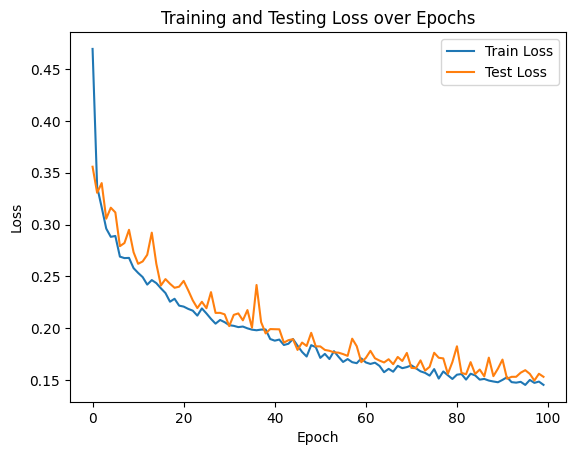

In [12]:

plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Training and Testing Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 잘 되는지 결과 이미지 출력해보기

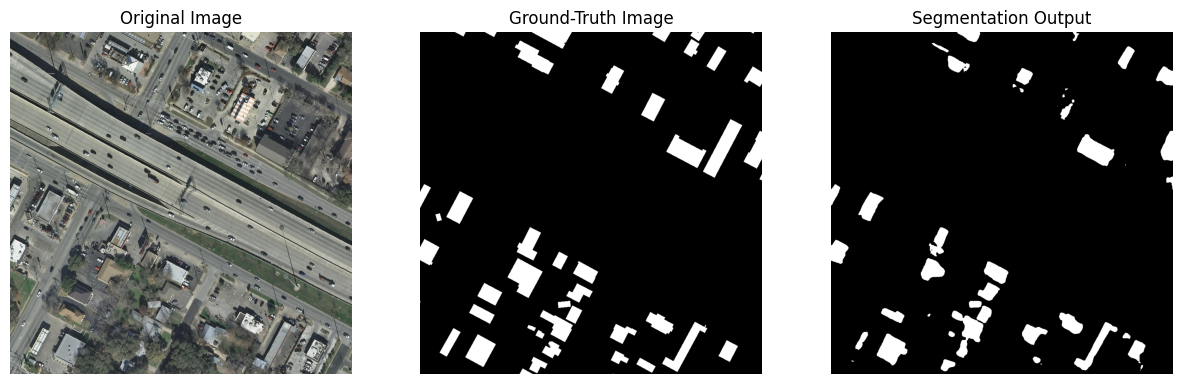

In [15]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2

# 모델 인스턴스 생성 및 가중치 로드
model_trained = model # Unet
# model_trained = Unet_resnet.to(device) # Unet + Resnet
# model_trained.load_state_dict(torch.load('./model.pt')) # 가중치파일 경로
model_trained.eval() # 평가 모드로 설정

# 이미지 전처리
def preprocess_image(image_path):
    input_image = Image.open(image_path)
    preprocess = A.Compose(
    [
        A.Normalize(),
        ToTensorV2()
    ])
    input_tensor = preprocess(image=np.array(input_image))['image']
    input_batch = input_tensor.unsqueeze(0) # 배치 차원 추가
    return input_batch

# 이미지 경로
image_path = '/content/drive/MyDrive/인지프/inria/cropped_1024/austin1/images/austin1_0_0.jpg'
gt_path = '/content/drive/MyDrive/인지프/inria/cropped_1024/austin1/binary_masks/austin1_0_0.tif'

# 이미지 전처리 및 예측 수행
with torch.no_grad():
    input_batch = preprocess_image(image_path)
    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        model_trained.to('cuda')

    output = model_trained(input_batch).logits

# 결과 처리
output = torch.sigmoid(output).squeeze(0).permute(1,2,0).cpu().numpy() # Sigmoid 적용 및 이미지 형태로 변환
output = (output > 0.5).astype(np.uint8) # Threshold 적용

# 원본 이미지 보기
plt.figure(figsize=(15, 5))  # 전체 그림의 크기를 늘림

original_image = Image.open(image_path)
plt.subplot(1, 3, 1)
plt.imshow(original_image)
plt.axis('off')
plt.title("Original Image")

# ground truth 이미지 보기
gt_image = Image.open(gt_path)
plt.subplot(1, 3, 2)
plt.imshow(gt_image)
plt.axis('off')
plt.title("Ground-Truth Image")

# 결과 이미지 보기 (Matplotlib 사용)
plt.subplot(1, 3, 3)
plt.imshow(output, cmap='gray')  # 'gray'는 흑백 이미지인 경우 사용
plt.axis('off')  # 축 제거
plt.title("Segmentation Output")

plt.show()


In [16]:
# model = Unet_resnet.to(device) # Unet + Resnet
# model.load_state_dict(torch.load('./model50.pt')) # 가중치파일 경로
model.eval() # 평가 모드로 설정

all_true_masks = []
all_predicted_masks = []
with torch.no_grad():
    model.eval()
    result = []
    for images, masks in tqdm(test_dataloader):
        images = images.float().to(device)
        true_masks = masks.float().to(device)

        outputs = model(images).logits

        # CPU로 이동
        true_masks = true_masks.squeeze().cpu().numpy()
        outputs = outputs.squeeze().cpu().numpy()
        outputs = (outputs > 0.5).astype(np.uint8)


        # 리스트에 추가
        all_true_masks.extend(true_masks)
        all_predicted_masks.extend(outputs)

# 실제 마스크와 예측 마스크 비교
true_masks_flat = np.concatenate(all_true_masks).ravel()
predicted_masks_flat = np.concatenate(all_predicted_masks).ravel()

# Precision, Recall, IoU, Dice 계산
# precision = precision_score(true_masks_flat, predicted_masks_flat)
# recall = recall_score(true_masks_flat, predicted_masks_flat)
iou = jaccard_score(true_masks_flat, predicted_masks_flat)
dice_coefficient = f1_score(true_masks_flat, predicted_masks_flat)

# 결과 출력
# print(f'Precision: {precision}')
# print(f'Recall: {recall}')
print(f'IoU: {iou}')
print(f'Dice Coefficient: {dice_coefficient}')



100%|██████████| 36/36 [00:10<00:00,  3.60it/s]


IoU: 0.66243920126917
Dice Coefficient: 0.7969484848088743
